## Tensorflow implementation of https://phillipi.github.io/pix2pix
support tensorflow 1.3+

In [1]:
import numpy as np
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
# Weights initializations
# bias are initailized as 0

conv_init = tf.random_normal_initializer(stddev=0.02)
gamma_init = tf.random_normal_initializer(stddev=0.02, mean=1)


In [3]:
def LeakyReLU(_):
    return tf.maximum(_*0.2, _)

def __LeakyReLU(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
def ZeroPadding2D(_):
    return tf.pad(_, [[0,0],[1,1],[1,1],[0,0]])

class Model:
    def __init__(self, BUILDER, inputs, outputs, scope_name=None, **kwargs):
        self.inputs = inputs
        self.outputs = outputs
        self.scope_name=scope_name
        self.kwargs =kwargs
        self.BUILDER=BUILDER
        self.trainable_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.scope_name)
    def __call__(self, **kwargs):
        m = self.BUILDER(scope_name=self.scope_name, **self.kwargs, **kwargs)
        print(m.scope_name)
        return m.outputs
        

In [4]:
# Basic discriminator
def conv2d(_, f, *a, **k):
    return tf.layers.conv2d(_, f, *a, kernel_initializer = conv_init, **k)

def batchnorm(_, name=None):
    return tf.layers.batch_normalization(_, epsilon=1e-5, training=True,  fused=True,
                                         gamma_initializer = gamma_init, axis=3)

def BASIC_D(nc_in, nc_out, ndf, max_layers=3, scope_name=None, input_a=None, input_b=None):
    reuse = None if scope_name is None else True
    with tf.variable_scope(scope_name, "BASIC_D", [nc_in, nc_out, ndf, max_layers], reuse=reuse) as scope:
        scope_name = scope.name
        if input_a is None:
            input_a = tf.placeholder(tf.float32,shape=(None, 256, 256, nc_in), name='input_a')
        if input_b is None:
            input_b = tf.placeholder(tf.float32, shape=(None, 256, 256, nc_out), name='input_b')
        _ = tf.concat([input_a, input_b], axis=-1)
        _ = conv2d(_, ndf, kernel_size=4, strides=2, padding="same", 
                   name = 'First', activation=LeakyReLU)
    
        for layer in range(1, max_layers):        
            out_feat = ndf * min(2**layer, 8)
            _ = conv2d(_, out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer))
            _ = batchnorm(_, name='batch_{}'.format(layer))        
            _ = LeakyReLU(_)
    
        out_feat = ndf*min(2**max_layers, 8)
        _ = ZeroPadding2D(_)
        _ = conv2d(_, out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') 
        _ = batchnorm(_, name='batch_last')
        _ = LeakyReLU(_)
    
        # final layer
        _ = ZeroPadding2D(_)
        _ = conv2d(_, 1, kernel_size=4, name = 'final', activation = tf.nn.sigmoid)    
    return Model(BASIC_D, inputs=[input_a, input_b], outputs=[_], scope_name=scope_name,
                nc_in=nc_in, nc_out=nc_out, ndf=ndf, max_layers=max_layers)

In [5]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True, input_a=None, scope_name=None):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(x, nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s))
        if s>2:
            if use_batchnorm:
                x = batchnorm(x, name='batch_{}.1'.format(s))
            x2 = LeakyReLU(x)
            x2 = block(x2, s//2, nf_next)
            x = tf.concat([x, x2], axis=-1)
        x = tf.nn.relu(x)
        x = tf.layers.conv2d_transpose(x, nf_out, kernel_size=4, strides=2, 
                                       use_bias=(not use_batchnorm), padding='same',
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))
                        
        if use_batchnorm:
            x = batchnorm(x, name='batch_{}.2'.format(s))
        if s <=8:
            x = tf.layers.dropout(x, rate=0.5, training=True)
        return x
    
    s = isize if fixed_input_size else None
    reuse = None if scope_name is None else True
    with tf.variable_scope(None, "UNET_G", [isize, nc_in, nc_out, ngf, fixed_input_size], reuse=reuse) as scope:
        scope_name = scope.name
        if input_a is None:
            input_a = tf.placeholder(shape=(None, s, s, nc_in), dtype=tf.float32, name='input_a')        
        _ = block(input_a, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
        _ = tf.nn.tanh(_)
    return Model(UNET_G, inputs=[input_a], outputs=[_], scope_name=scope_name, 
                isize=isize, nc_in=nc_in, nc_out=nc_out, ngf=ngf, fixed_input_size=fixed_input_size)

In [6]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [7]:
netD = BASIC_D(nc_in, nc_out, ndf)


In [8]:
netG = UNET_G(imageSize, nc_in, nc_out, ngf, input_a=netD.inputs[0])


In [9]:
def build_functions():
    assert netG.inputs[0] is netD.inputs[0]
    real_A = netG.inputs[0]
    fake_B = netG.outputs[0]
    def netG_generate(A, sess): 
        return sess.run(netG.outputs[0],feed_dict={real_A:A})
    real_B = netD.inputs[1]
    output_D_real = netD.outputs[0] #(input_a=real_A, input_b=real_B)[0]
    output_D_fake = netD(input_a=real_A, input_b=fake_B)[0]

    loss_fn = lambda output, target : -tf.reduce_mean(tf.log(output+1e-12)*target+tf.log(1-output+1e-12)*(1-target))

    loss_D_real = loss_fn(output_D_real, tf.ones_like(output_D_real))
    loss_D_fake = loss_fn(output_D_fake, tf.zeros_like(output_D_fake))
    loss_G_fake = loss_fn(output_D_fake, tf.ones_like(output_D_fake))


    loss_L1 = tf.reduce_mean(tf.abs(fake_B-real_B))

    loss_D = loss_D_real +loss_D_fake

    optimizerD = tf.train.AdamOptimizer(lrD, beta1=0.5).minimize(loss_D, var_list=netD.trainable_weights)

    loss_G = loss_G_fake   + 100 * loss_L1

    optimizerG = tf.train.AdamOptimizer(lrG, beta1=0.5).minimize(loss_G, var_list=netG.trainable_weights)
    def netD_train(A, B, sess):
        return sess.run(
            [optimizerD, loss_D/2],feed_dict={real_A:A, real_B:B})[1:]
    def netG_train(A, B, sess):
        return sess.run(
            [optimizerG, loss_G_fake, loss_L1],feed_dict={real_A:A, real_B:B})[1:]
    return netG_generate, netD_train, netG_train
netG_generate, netD_train, netG_train = build_functions()

BASIC_D


In [10]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

data = "edges2shoes"
data = "facades"
direction = 0
trainAB = load_data('pix2pix/{}/train/*.jpg'.format(data))
valAB = load_data('pix2pix/{}/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)

In [11]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [12]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

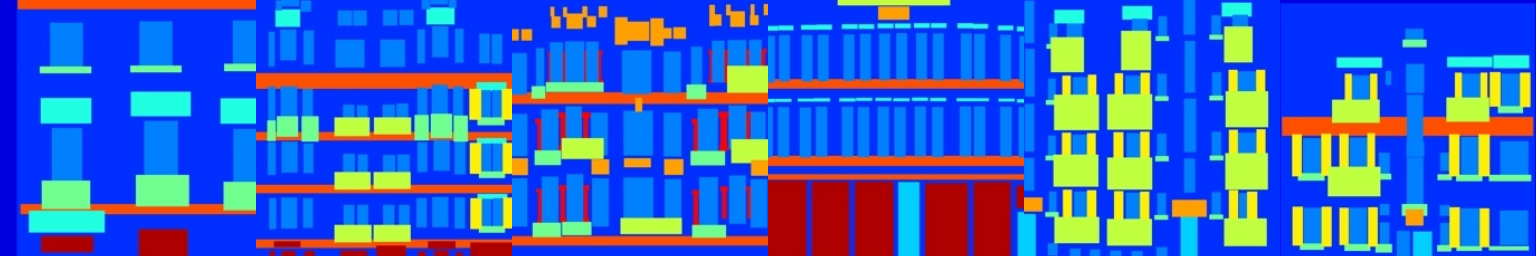

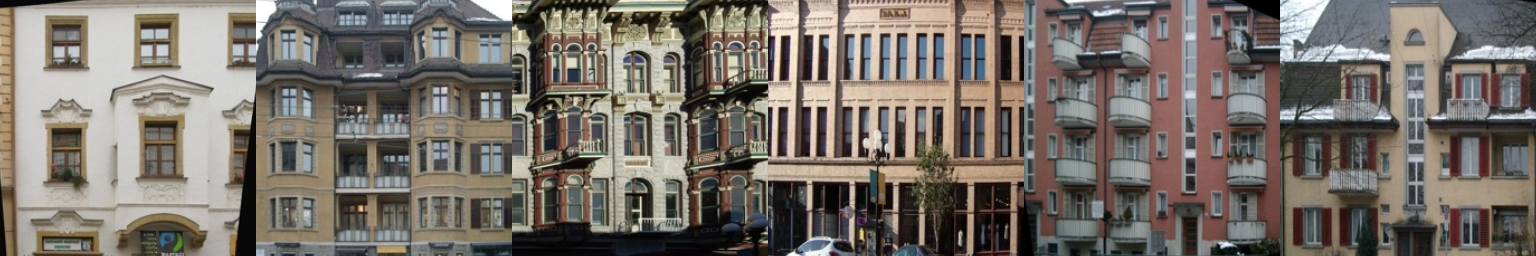

In [13]:
train_batch = minibatch(trainAB, 6, direction=direction)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
del train_batch, trainA, trainB

In [14]:
def netG_gen(A):
    return np.concatenate([netG_generate(A[i:i+1], sess) for i in range(A.shape[0])], axis=0)

In [15]:
config = tf.ConfigProto(allow_soft_placement = True)

[1/50][500] Loss_D: 0.355344 Loss_G: 2.286844 loss_L1: 0.342821 102.48849868774414


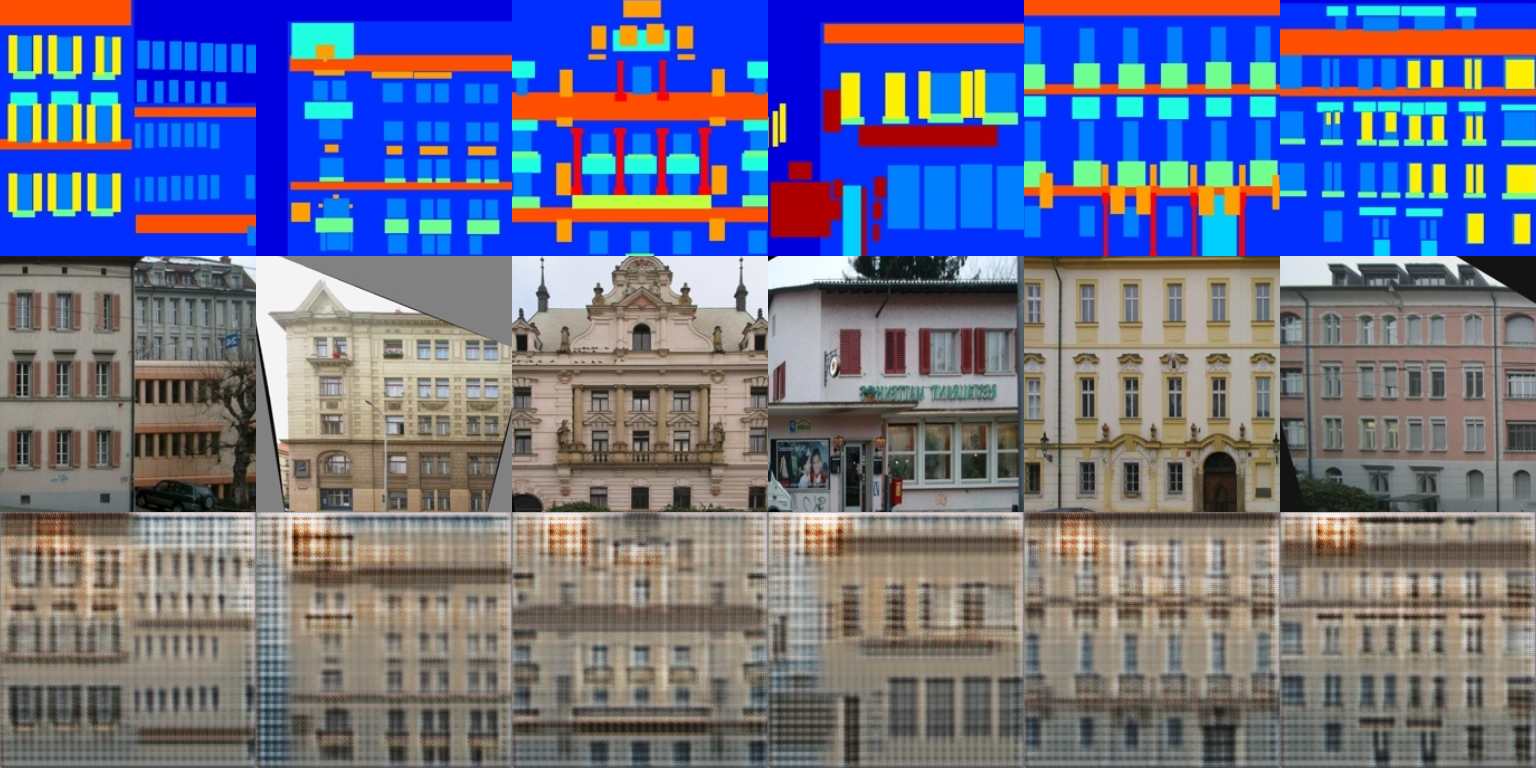

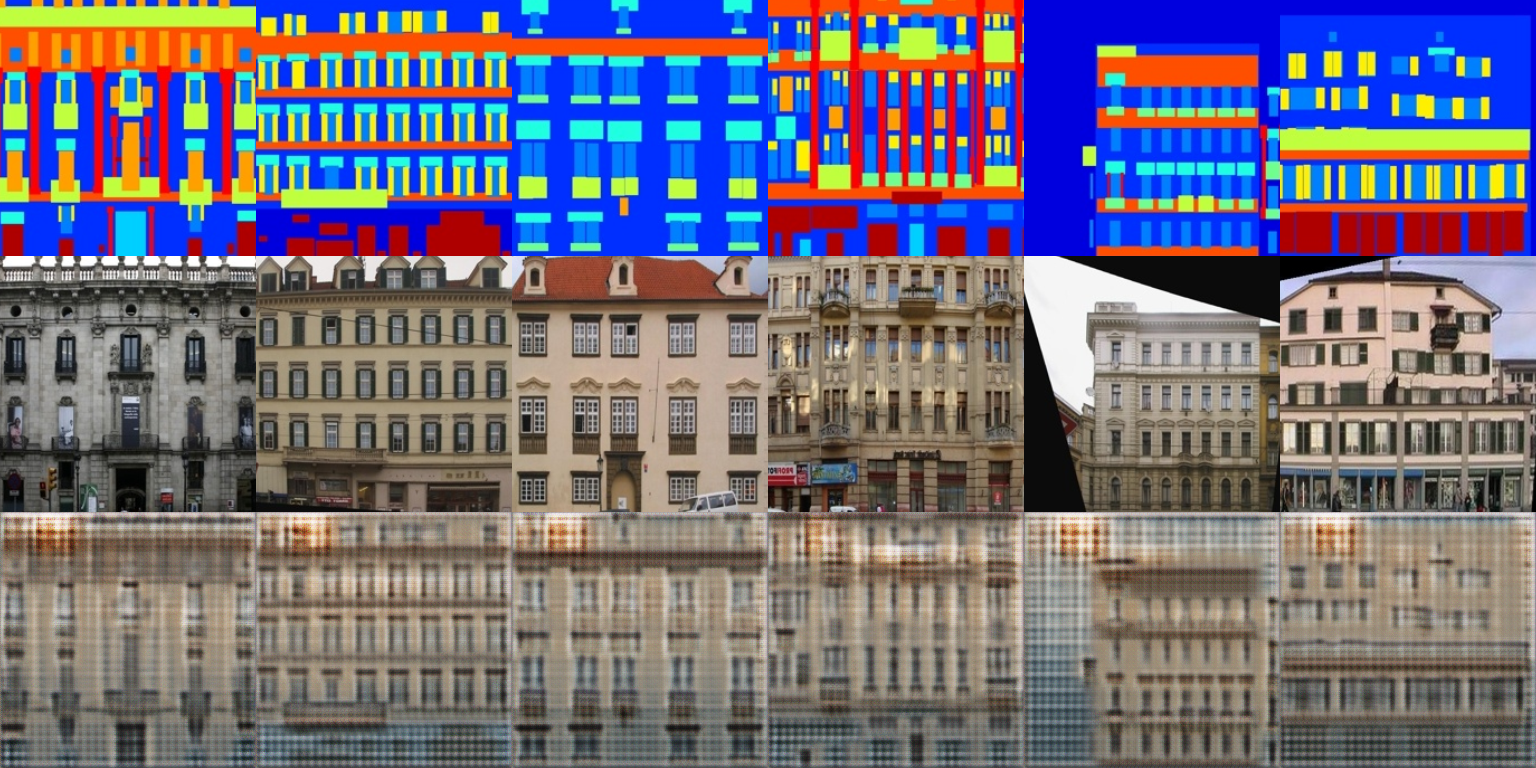

KeyboardInterrupt: 

In [16]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 50
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    while epoch < niter: 
        epoch, trainA, trainB = next(train_batch)        
        errD,  = netD_train(trainA, trainB, sess)
        errD_sum +=errD

        errG, errL1 = netG_train(trainA, trainB, sess)
        errG_sum += errG
        errL1_sum += errL1
        gen_iterations+=1
        if gen_iterations%display_iters==0:
            if gen_iterations%(5*display_iters)==0:
                clear_output()
            print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
            % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
            _, valA, valB = train_batch.send(6) 
            fakeB = netG_gen(valA)
            showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
            errL1_sum = errG_sum = errD_sum = 0
            _, valA, valB = next(val_batch)
            fakeB = netG_gen(valA)
            showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        

In [17]:
tf.global_variables()

[<tf.Variable 'BASIC_D/First/kernel:0' shape=(4, 4, 6, 64) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/First/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/pyramid.1/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization/moving_mean:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization/moving_variance:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/pyramid.2/kernel:0' shape=(4, 4, 128, 256) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization_1/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization_1/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization_1/moving_mean:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'BASIC_D/batch_normalization_1/moving_variance